In [3]:
import pandas as pd
driver_id = pd.read_csv(r"C:\Users\cangr\Downloads\driver_ids.csv")
ride_ts = pd.read_csv(r"C:\Users\cangr\Downloads\ride_timestamps.csv")
ride_id = pd.read_csv(r"C:\Users\cangr\Downloads\ride_ids.csv")

In [5]:
ride_ts_dict={}
for counter,elem in enumerate(ride_ts['ride_id']):
    if elem not in ride_ts_dict:
        ride_ts_dict[elem] = ride_ts['ride_picked_up_at'][counter]
    else:
        print('Error')

driver_id_dict={}
for counter,elem in enumerate(driver_id['driver_id']):
    if elem not in driver_id_dict:
        driver_id_dict[elem] = driver_id['driver_onboard_date'][counter]
    else:
        print('Error')

In [6]:
import time
import datetime
# find the last timestamp
last_ts=0
for counter,elem in enumerate(ride_ts['ride_picked_up_at']):
    last_ts = max(last_ts,
                  time.mktime(datetime.datetime.strptime(elem, "%Y-%m-%d %H:%M:%S").timetuple()))

In [7]:
driver_ride_id_dict={}
unknown_ride_ide_count, unknown_driver_ide_count=0, 0
for counter,elem in enumerate(ride_id['driver_id']):
    if ride_id['ride_id'][counter] not in ride_ts_dict:
#         print('Unkown ride_id (no mapping between driver_id and ride_id)')
        unknown_ride_ide_count+=1
        continue
        
    if elem not in driver_id_dict:
        unknown_driver_ide_count+=1
        continue
    
    onboard_time = time.mktime(datetime.datetime.strptime(driver_id_dict[elem], "%Y-%m-%d %H:%M:%S").timetuple())
    thisride_time= time.mktime(datetime.datetime.strptime(ride_ts_dict[ride_id['ride_id'][counter]], "%Y-%m-%d %H:%M:%S").timetuple())
    time_range = float(format((thisride_time-onboard_time)/3600.0/24.0,'.2f'))
    vacum_to_date = float(format((last_ts-thisride_time)/3600.0/24.0,'.2f'))
    first_time_range = float(format((thisride_time-onboard_time)/3600.0/24.0,'.2f'))
    
    if elem not in driver_ride_id_dict:
        driver_ride_id_dict[elem]=[[ride_id['ride_id'][counter],ride_id['ride_distance'][counter],
                            ride_id['ride_duration'][counter],ride_id['ride_prime_time'][counter],
                            first_time_range,time_range,vacum_to_date]]
    else:
        driver_ride_id_dict[elem].append([ride_id['ride_id'][counter],ride_id['ride_distance'][counter],
                                  ride_id['ride_duration'][counter],ride_id['ride_prime_time'][counter],
                                  first_time_range,time_range,vacum_to_date])

In [8]:
driver_freq_dict={} #drive freqent and last time
for elem in driver_ride_id_dict.keys():
    driver_freq_dict[elem]=[]
    max_range,last_to_date,first_time_range = 0,0,float('inf')
    ride_distance_sum, ride_duration_sum = 0, 0
    for counter,items in enumerate(driver_ride_id_dict[elem]):
        last_to_date = max(last_to_date,items[-1])
        max_range = max(max_range,items[-2])
        first_time_range = min(first_time_range,items[-3])
        ride_duration_sum += items[-4]
        ride_distance_sum += items[-5]
        
    driver_freq_dict[elem]=[counter,max_range,
                            float(format(counter/max_range,'.2f')),last_to_date,
                           first_time_range, float(format(ride_duration_sum/counter,'.2f')), 
                            float(format(ride_distance_sum/counter,'.2f'))]

#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer]

In [26]:
#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer]

# method 1: 取最后一次的记录到截至日期的间隔
# driver_freq_dict
ratio = 45
churn_ratio=[]
for ratio in range(ratio,90,5):
    crit_item_index = 3
    sum_churn_freq,sum_unchurn_freq = 0,0
    count_churn,count_unchurn = 0,0
    driver_churn_dict, driver_unchurn_dict = {}, {}
    for elem in driver_freq_dict.keys():
        if driver_freq_dict[elem][crit_item_index]<ratio:
            driver_churn_dict[elem]=driver_freq_dict[elem]
            sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
            count_churn+=1
        else:
            driver_unchurn_dict[elem]=driver_freq_dict[elem]
            sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
            count_unchurn+=1
    print(ratio)
    print(count_churn, count_unchurn)
    print(sum_churn_freq/count_churn, sum_unchurn_freq/count_unchurn)
    print((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
    churn_ratio.append((sum_churn_freq/count_churn)/(sum_unchurn_freq/count_unchurn))
    print('----------------------------')

45
34 803
43.51323529411764 69.22887920298882
0.6285416692437084
----------------------------
50
110 727
45.86945454545456 71.56066024759288
0.6409870225728876
----------------------------
55
195 642
48.69958974358974 74.10252336448603
0.657192056794779
----------------------------
60
265 572
51.1072075471698 76.0958566433567
0.6716161667868096
----------------------------
65
344 493
53.683488372093024 78.30247464503047
0.6855912104369244
----------------------------
70
436 401
56.54600917431194 80.83835411471324
0.6994948102737301
----------------------------
75
528 309
59.336837121212135 83.30223300970874
0.7123078815221738
----------------------------
80
610 227
61.76013114754102 85.4474008810573
0.7227853686680424
----------------------------
85
712 125
64.67313202247195 88.18376000000002
0.7333905020887285
----------------------------


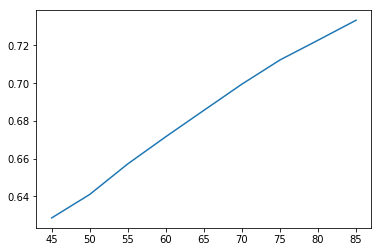

In [33]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.plot(np.linspace(45, 90, len(churn_ratio), endpoint=False),churn_ratio)
# pick 50, because it has the largest gradient

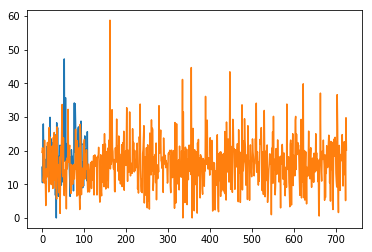

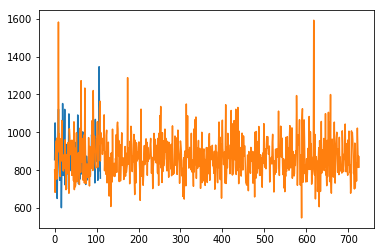

In [44]:
#[0:total number of rides, 1:total range of ride, 2:frequent of ride per day, 3:vacum time from last ride,
# 4:vacum time from on board, 5:mean time per costumer, 6:mean distance per customer]
ratio = 50
# churn_ratio=[]
# for ratio in range(ratio,90,5):
crit_item_index = 3
sum_churn_freq,sum_unchurn_freq = 0,0
count_churn,count_unchurn = 0,0
driver_churn_dict, driver_unchurn_dict = {}, {}
for elem in driver_freq_dict.keys():
    if driver_freq_dict[elem][crit_item_index]<ratio:
        driver_churn_dict[elem]=driver_freq_dict[elem]
        sum_churn_freq = driver_churn_dict[elem][crit_item_index]+sum_churn_freq
        count_churn+=1
    else:
        driver_unchurn_dict[elem]=driver_freq_dict[elem]
        sum_unchurn_freq = driver_unchurn_dict[elem][crit_item_index]+sum_unchurn_freq
        count_unchurn+=1

# insight
churn_distant_list,churn_duration_list,unchurn_distant_list,unchurn_duration_list=[],[],[],[]
for elem in driver_churn_dict.keys():
    churn_duration_list.append(driver_churn_dict[elem][5])
    churn_distant_list.append(driver_churn_dict[elem][6])
    
for elem in driver_unchurn_dict.keys():
    unchurn_duration_list.append(driver_unchurn_dict[elem][5])
    unchurn_distant_list.append(driver_unchurn_dict[elem][6])
    
plt.plot(churn_duration_list)
plt.plot(unchurn_duration_list)
plt.show()

plt.plot(churn_distant_list)
plt.plot(unchurn_distant_list)
plt.show()
